In [1]:
import logging
import json
import torch
from types import SimpleNamespace
from vilbert.vilbert import VILBertActionGrounding, BertConfig
from pytorch_transformers.tokenization_bert import BertTokenizer
from pytorch_transformers.optimization import AdamW, WarmupLinearSchedule
import torch.distributed as dist
from VLN_config import config as args
import random
import pandas as pd
from dataLoader import DataLoader

In [2]:
import sys
import os
import torch
import yaml

import numpy as np
import matplotlib.pyplot as plt
import PIL

from PIL import Image
import cv2
import argparse
import glob
import pdb

import torchvision.models as models
import torchvision.transforms as transforms

from faster_rcnn import feature_extractor_new as f_extractor
from faster_rcnn.feature_extractor_new import featureExtractor
#%matplotlib inline  

In [3]:
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger = logging.getLogger(__name__)
print(args)

namespace(adam_epsilon=1e-08, baseline=False, bert_model='bert-base-uncased', best_features=5, clean_train_sets=True, config_file='config/bert_base_6layer_6conect.json', distributed=False, do_lower_case=True, dynamic_attention=False, from_pretrained='save_vilbert_action_grounding/vilberActionGrounding.bin', gradient_accumulation_steps=1, img_weight=1, in_memory=False, learning_rate=0.0001, local_rank=-1, max_temporal_memory_buffer=3, mean_layer=False, num_key_frames=6, num_train_epochs=10.0, num_workers=0, objective=1, predict_feature=False, save_name='', seed=42, split='mteval', start_epoch=0, task_specific_tokens=True, tasks='1', threshold_similarity=0.7, track_temporal_features=True, train_batch_size=4, use_tensorboard=True, visual_target=0, warmup_proportion=0.1, without_coattention=False)


In [4]:
tokenizer = BertTokenizer.from_pretrained(
    args.bert_model, do_lower_case=args.do_lower_case
)

07/30/2020 11:33:19 - INFO - pytorch_transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/mikel/.cache/torch/pytorch_transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [5]:
config = BertConfig.from_json_file(args.config_file)
bert_weight_name = json.load(
    open("config/" + args.bert_model + "_weight_name.json", "r")
)

tokenizer = BertTokenizer.from_pretrained(
    args.bert_model, do_lower_case=args.do_lower_case
)

config.track_temporal_features = args.track_temporal_features
config.mean_layer = args.mean_layer
config.max_temporal_memory_buffer = args.max_temporal_memory_buffer
config.visualization = True

#The path of the finetuned ActionGrounding weights
args.from_pretrained = "save_vilbert_action_grounding/vilberActionGrounding.bin"

print(args.from_pretrained)
model = VILBertActionGrounding.from_pretrained(
    args.from_pretrained, config=config, default_gpu=True
)

07/30/2020 11:33:20 - INFO - pytorch_transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/mikel/.cache/torch/pytorch_transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
07/30/2020 11:33:20 - INFO - vilbert.utils -   loading weights file save_vilbert_action_grounding/vilberActionGrounding.bin


save_vilbert_action_grounding/vilberActionGrounding.bin


In [6]:
# load data
frcnn_model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
data_loader = DataLoader("json_data.json", frcnn_model, save_or_not = False)
path = 'DataLoader.pt'
data_loaded = data_loader.load_dataloader(path)

17


In [9]:
features_masked, pos_enc, spatial, image_mask, tokenized_text, masked_text, masked_lm_token, input_mask, segment_ids, co_attention_mask, infos, masked_img_labels  = data_loaded

In [8]:
#Forward the model with one input example
pred_t_train, pred_v_train, att_train = model(input_ids = masked_text[1].unsqueeze(0).cpu(),
                                image_feat = features_masked[1].unsqueeze(0).cpu(), # Linear(2048*config.max_temporal_memory_buffer, 2048)
                                image_loc = spatial[1].unsqueeze(0).cpu(),  #Linear(in_features=5, out_features=1024, bias=True)
                                image_pos_input = pos_enc[1].unsqueeze(0).cpu(),   #Linear(7, 2048)/(6, 2048)
                                token_type_ids = segment_ids[1].unsqueeze(0).cpu(), 
                                attention_mask = input_mask[1].unsqueeze(0).cpu(), 
                                image_attention_mask = image_mask[1].unsqueeze(0).cpu(),
                                output_all_attention_masks=True)

In [15]:
print(tokenized_text[5])
print(masked_lm_token[5])

tensor([  101,  2404,  1996, 14804,  2571,  1999,  1996,  5239,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0])
tensor([  -1,   -1,   -1,   -1,   -1,   -1, 1996,   -1,   -1,   -1,   -1,   -1,
          -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
          -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
          -1])


In [24]:
import json
from IPython.core.display import display, HTML, Javascript
import os
#from .util import format_special_chars, format_attention

def format_attention(attention):
    squeezed = []
    for layer_attention in attention:
        # 1 x num_heads x seq_len x seq_len
        if len(layer_attention.shape) != 4:
            raise ValueError("The attention tensor does not have the correct number of dimensions. Make sure you set "
                             "output_attentions=True when initializing your model.")
        squeezed.append(layer_attention.squeeze(0))
    # num_layers x num_heads x seq_len x seq_len
    return torch.stack(squeezed)

def format_special_chars(tokens):
    return [t.replace('Ġ', ' ').replace('▁', ' ').replace('</w>', '') for t in tokens]


def head_view(attention, tokens, tokens_r, sentence_b_start = None, prettify_tokens=False):
    """Render head view
        Args:
            attention: list of ``torch.FloatTensor``(one for each layer) of shape
                ``(batch_size(must be 1), num_heads, sequence_length, sequence_length)``
            tokens: list of tokens
            sentence_b_index: index of first wordpiece in sentence B if input text is sentence pair (optional)
            prettify_tokens: indicates whether to remove special characters in wordpieces, e.g. Ġ
    """

    if sentence_b_start is not None:
        vis_html = """
        <span style="user-select:none">
            Layer: <select id="layer"></select>
            Attention: <select id="filter">
              <option value="all">All</option>
              <option value="aa">Sentence A -> Sentence A</option>
              <option value="ab">Sentence A -> Sentence B</option>
              <option value="ba">Sentence B -> Sentence A</option>
              <option value="bb">Sentence B -> Sentence B</option>
            </select>
            </span>
        <div id='vis'></div>
        """
    else:
        vis_html = """
              <span style="user-select:none">
                Layer: <select id="layer"></select>
              </span>
              <div id='vis'></div> 
            """

    display(HTML(vis_html))
#     __location__ = os.path.realpath(
#         os.path.join(os.getcwd(), os.path.dirname(__file__)))
    __location__ = os.getcwd()
    vis_js = open(os.path.join(__location__, 'head_view.js')).read()
    print(vis_js)
    if prettify_tokens:
        tokens = format_special_chars(tokens)

    attn = format_attention(attention)
    attn_data = {
        'all': {
            'attn': attn.tolist(),
            'left_text': tokens,
            'right_text': tokens_r
        }
    }
    if sentence_b_start is not None:
        slice_a = slice(0, sentence_b_start)  # Positions corresponding to sentence A in input
        slice_b = slice(sentence_b_start, len(tokens))  # Position corresponding to sentence B in input
        attn_data['aa'] = {
            'attn': attn[:, :, slice_a, slice_a].tolist(),
            'left_text': tokens[slice_a],
            'right_text': tokens[slice_a]
        }
        attn_data['bb'] = {
            'attn': attn[:, :, slice_b, slice_b].tolist(),
            'left_text': tokens[slice_b],
            'right_text': tokens[slice_b]
        }
        attn_data['ab'] = {
            'attn': attn[:, :, slice_a, slice_b].tolist(),
            'left_text': tokens[slice_a],
            'right_text': tokens[slice_b]
        }
        attn_data['ba'] = {
            'attn': attn[:, :, slice_b, slice_a].tolist(),
            'left_text': tokens[slice_b],
            'right_text': tokens[slice_a]
        }
    params = {
        'attention': attn_data,
        'default_filter': "all"
    }
    attn_seq_len = len(attn_data['all']['attn'][0][0])
    if attn_seq_len != len(tokens):
        pass
        #raise ValueError(f"Attention has {attn_seq_len} positions, while number of tokens is {len(tokens)}")

    display(Javascript('window.params = %s' % json.dumps(params)))
    display(Javascript(vis_js))


In [25]:
print(att_train[2][0].keys())
att_list = []
for i in range(len(att_train[2])):
    att_list.append(att_train[2][i]["attn2"])
print(len(att_list))
input_id_list = masked_text[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list) 
img_reg = [1]*att_list[0].shape[2] + [0]*att_list[0].shape[-1]
print(tokens)
print(img_reg)

dict_keys(['attn1', 'queries1', 'keys1', 'attn2', 'querues2', 'keys2'])
6
['[CLS]', 'go', 'to', '[MASK]', 'drawer', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [26]:
head_view(att_list, tokens, img_reg)

/**
 * @fileoverview Transformer Visualization D3 javascript code.
 *
 *
 *  Based on: https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/visualization/attention.js
 *
 * Change log:
 *
 * 12/19/18  Jesse Vig   Assorted cleanup. Changed orientation of attention matrices.
 */

requirejs(['jquery', 'd3'], function($, d3) {

const TEXT_SIZE = 15;
const BOXWIDTH = 110;
const BOXHEIGHT = 22.5;
const MATRIX_WIDTH = 115;
const CHECKBOX_SIZE = 20;
const TEXT_TOP = 30;
const HEAD_COLORS = d3.scale.category10();

var params = window.params;
var config = {};
initialize();

function lighten(color) {
  var c = d3.hsl(color);
  var increment = (1 - c.l) * 0.6;
  c.l += increment;
  c.s -= increment;
  return c;
}

function transpose(mat) {
  return mat[0].map(function(col, i) {
    return mat.map(function(row) {
      return row[i];
    });
  });
}

function zip(a, b) {
  return a.map(function (e, i) {
    return [e, b[i]];
  });
}

function render() {

  var attnData = config.att

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

torch.Size([1, 37, 30522])
torch.Size([5, 37])


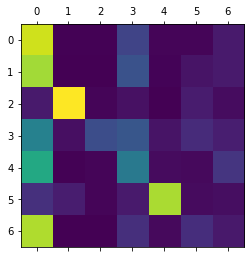

In [9]:
print(pred_t_train.shape)
print(att_train[0][0]["attn"][0,0,:5,:].shape) 
#Only 7 firts elements because the sentence is 5 + 2 special tokens
plt.matshow(att_train[0][0]["attn"][0,2,:7,:7].detach().numpy())